#Feature Engineering & Data Cleansing

In [8]:
import numpy as np
import pandas as pd
import datetime

# 결측값 유무
import missingno as msno

import warnings #경고 미출력
warnings.filterwarnings('ignore')
from collections import Counter # count

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager, rc
palette = sns.color_palette('twilight') + sns.color_palette('bright')

# 지도 관련 시각화
import folium
from folium.plugins import MarkerCluster
import geopy.distance

#데이터 샘플링
import random
from sklearn.preprocessing import LabelEncoder #인코딩
from sklearn.preprocessing import OneHotEncoder

#validation
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#model
import lightgbm as lgbm

#processing bar
from tqdm import tqdm_notebook

In [7]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/commit/Dacon/229255_bus_riders_at_rush_hour_data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/commit/Dacon/229255_bus_riders_at_rush_hour_data/test.csv")
weather = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/commit/Dacon/weather.csv', encoding='cp949') #날씨data(외부)

In [9]:
#date 변수 변환
train['date2'] = pd.to_datetime(train['date'])
test['date2']=pd.to_datetime(test['date'])
train['weekday'] = train['date2'].dt.weekday #요일별로 변수 변경(train) -> 숫자로 나옴.

test['date2'] = pd.to_datetime(test['date'])
test['weekday'] = test['date2'].dt.weekday #요일별로 변수 변경(test)

del train['date2'] #임의 컬럼 삭제
del test['date2']

In [10]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,6
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6


In [11]:
#holiday(공휴일) , holiweekend(주말)
holidays = ['09-12', '09-13', '09-14', '10-03', '10-09']
holidays = ['2019-'+day for day in holidays]

train['holiday'] = train.apply(lambda row: 'Y' if row.date in holidays else 'N', axis=1)
train['holiweekend'] = train.apply(lambda row: 'H' if row.holiday == 'Y' else 'N', axis=1)
train['holiweekend'] = train.apply(lambda row: 'WE' if row.holiweekend =='N' and row.weekday in [5,6] else row.holiweekend, axis=1)


test['holiday'] = test.apply(lambda row: 'Y' if row.date in holidays else 'N', axis=1)
test['holiweekend'] = test.apply(lambda row: 'H' if row.holiday == 'Y' else 'N', axis=1)
test['holiweekend'] = test.apply(lambda row: 'WE' if row.holiweekend =='N' and row.weekday in [5,6] else row.holiweekend, axis=1)

In [12]:
train['holiweekend']

0         WE
1         WE
2         WE
3         WE
4         WE
          ..
415418     N
415419     N
415420     N
415421     N
415422     N
Name: holiweekend, Length: 415423, dtype: object

##관측소와의 거리 칼럼 추가

In [13]:
# latitude / longitude를 묶어줘서 location컬럼 생성.
train['location'] = train.apply(lambda row: (row.latitude, row.longitude), axis=1)

jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

#정류장의 위치만 확인하기 위해 groupby를 실행함
data_loc=train[['location','station_name']].drop_duplicates(keep='first')

train['dist_jj'] = train['location'].apply(lambda x: geopy.distance.geodesic( x, jeju).km)
print("jeju done", datetime.datetime.now())
train['dist_gs'] = train['location'].apply(lambda x: geopy.distance.geodesic( x, gosan).km)
print("gosan done", datetime.datetime.now())
train['dist_ss'] = train['location'].apply(lambda x: geopy.distance.geodesic( x, seongsan).km)
print("sungsan done", datetime.datetime.now())
train['dist_sp'] = train['location'].apply(lambda x: geopy.distance.geodesic( x, po).km)
print("seoguipo done", datetime.datetime.now())

train['center_name'] = train[['dist_jj', 'dist_gs', 'dist_ss', 'dist_sp']].apply(lambda row: ['dist_jj', 'dist_gs', 'dist_ss', 'dist_sp'][row.argmin()][5:], axis=1)

jeju done 2023-09-03 09:23:59.298117
gosan done 2023-09-03 09:25:28.220749
sungsan done 2023-09-03 09:26:58.086640
seoguipo done 2023-09-03 09:28:32.717446


In [14]:
weather.head()

,날짜,현재일기,현재기온,체감온도,일강수
0,2019-09-01,흐림,26.2,75.0,0
1,2019-09-02,비 끝남,22.5,72.0,25.7
2,2019-09-03,흐림,25.4,77.0,12.1
3,2019-09-04,약한비단속,24.2,75.0,34.3
4,2019-09-05,구름많음,27.6,79.0,0.1


In [20]:
#datetime 변환
weather['날짜']=pd.to_datetime(weather['날짜'])

weather['hour']=weather['날짜'].dt.hour
weather['날짜']=weather['날짜'].dt.date

weather=weather[((weather['hour']>=6)<=12)].reset_index(drop=True)

weather=weather.groupby('날짜')[['현재기온']].mean().reset_index()


In [19]:
weather.head()

,날짜,현재기온
0,2019-09-01,26.2
1,2019-09-02,22.5
2,2019-09-03,25.4
3,2019-09-04,24.2
4,2019-09-05,27.6


상관관계 파악하기

In [21]:
train['68a']=train['6~7_ride']+train['7~8_ride'] # 6 ~ 8시 승차인원 (2시간단위로 묶어줌)
train['810a']=train['8~9_ride']+train['9~10_ride']
train['1012a']=train['10~11_ride']+train['11~12_ride']

train['68b']=train['6~7_takeoff']+train['7~8_takeoff'] # 6 ~ 8시 하차인원
train['810b']=train['8~9_takeoff']+train['9~10_takeoff']
train['1012b']=train['10~11_takeoff']+train['11~12_takeoff']

In [22]:
#test도 같이 묶어줌.
test['68a']=test['6~7_ride']+test['7~8_ride']
test['810a']=test['8~9_ride']+test['9~10_ride']
test['1012a']=test['10~11_ride']+test['11~12_ride']

test['68b']=test['6~7_takeoff']+test['7~8_takeoff']
test['810b']=test['8~9_takeoff']+test['9~10_takeoff']
test['1012b']=test['10~11_takeoff']+test['11~12_takeoff']

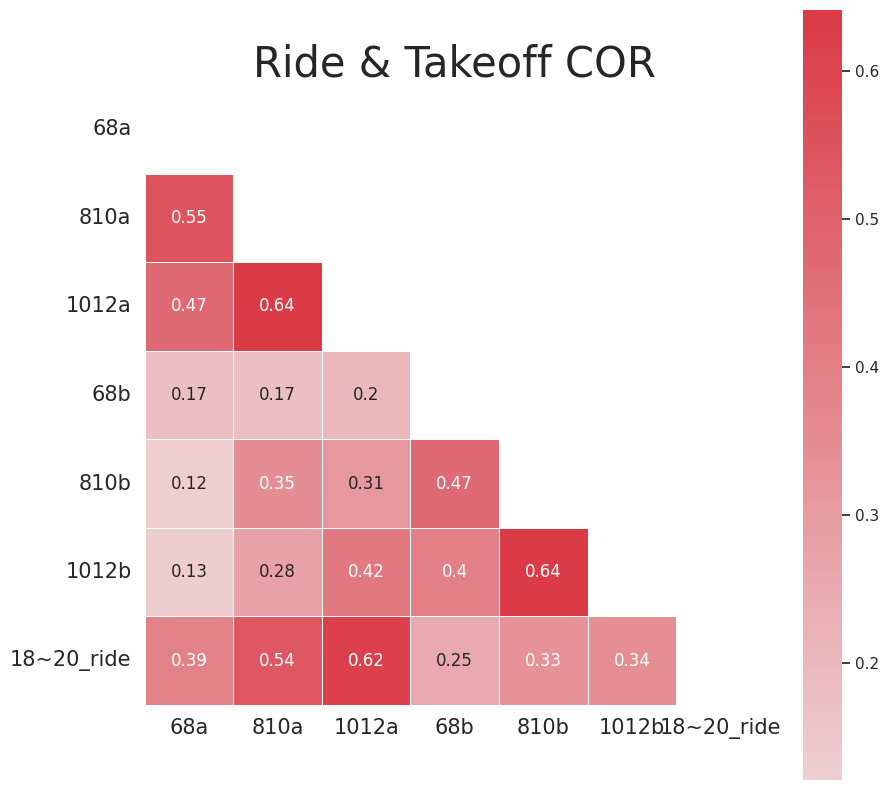

In [23]:
train2=train[['68a','810a','1012a','68b','810b','1012b','18~20_ride']]

cor=train2.corr()

sns.set(style="white")
mask=np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(10,10))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생성
plt.xticks(size=15)
plt.yticks(size=15,rotation=0)
plt.title("Ride & Takeoff COR",size=30);

In [25]:
#3가지 시간대로 나눔: 새벽, 아침, 정오


dawn_ride_cols, dawn_takoff_cols = ['6~7_ride','7~8_ride'], ['6~7_takeoff','7~8_takeoff']
morning_ride_cols, morning_takeoff_cols = ['8~9_ride','9~10_ride'], ['8~9_takeoff','9~10_takeoff']
noon_ride_cols, noon_takeoff_cols = ['10~11_ride','11~12_ride'], ['10~11_takeoff','11~12_takeoff']


def divide_time(df):
    # 승차
    df['dawn_ride'] = df[dawn_ride_cols].sum(axis=1) #새벽
    df['morning_ride'] = df[morning_ride_cols].sum(axis=1) #아침
    df['noon_ride'] = df[noon_ride_cols].sum(axis=1) #정오

    # 하차
    df['dawn_takeoff'] = df[dawn_takoff_cols].sum(axis=1)
    df['morning_takeoff'] = df[morning_takeoff_cols].sum(axis=1)
    df['noon_takeoff'] = df[noon_takeoff_cols].sum(axis=1)

     # 임의 컬럼 삭제
    drop_cols = dawn_ride_cols + morning_ride_cols + noon_ride_cols + dawn_takoff_cols + morning_takeoff_cols + noon_takeoff_cols
    df = df.drop(drop_cols, 1)

    return df

In [26]:
train = divide_time(train)
test = divide_time(test)

In [27]:
# 탑승

train['avg_dawn_ride'] = train.groupby(['date','bus_route_id'])['dawn_ride'].transform('mean')
train['avg_morning_ride'] = train.groupby(['date','bus_route_id'])['morning_ride'].transform('mean')
train['avg_noon_ride'] = train.groupby(['date','bus_route_id'])['noon_ride'].transform('mean')

test['avg_dawn_ride'] = test.groupby(['date','bus_route_id'])['dawn_ride'].transform('mean')
test['avg_morning_ride'] = test.groupby(['date','bus_route_id'])['morning_ride'].transform('mean')
test['avg_noon_ride'] = test.groupby(['date','bus_route_id'])['noon_ride'].transform('mean')

In [31]:
# 하차

train['avg_dawn_takeoff'] = train.groupby(['date','bus_route_id'])['dawn_takeoff'].transform('mean')
train['avg_morning_takeoff'] = train.groupby(['date','bus_route_id'])['morning_takeoff'].transform('mean')
train['avg_noon_takeoff'] = train.groupby(['date','bus_route_id'])['noon_takeoff'].transform('mean')

test['avg_dawn_takeoff'] = test.groupby(['date','bus_route_id'])['dawn_takeoff'].transform('mean')
test['avg_morning_takeoff'] = test.groupby(['date','bus_route_id'])['morning_takeoff'].transform('mean')
test['avg_noon_takeoff'] = test.groupby(['date','bus_route_id'])['noon_takeoff'].transform('mean')

In [32]:
#시외/시내(카테고리컬) 수치형으로 변환.

train['in_out'] = train['in_out'].map({'시내':0,'시외':1})
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

In [34]:
#앞서 만든 weekday 컬럼 원핫인코딩.-> 각각 칼럼으로 만들기

train = pd.get_dummies(train,columns=['weekday'])
test = pd.get_dummies(test,columns=['weekday'])

In [35]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,18~20_ride,holiday,...,avg_dawn_takeoff,avg_morning_takeoff,avg_noon_takeoff,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,N,...,0.16,0.32,1.88,0,0,0,0,0,0,1
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,5.0,N,...,0.16,0.32,1.88,0,0,0,0,0,0,1
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,2.0,N,...,0.16,0.32,1.88,0,0,0,0,0,0,1
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,53.0,N,...,0.16,0.32,1.88,0,0,0,0,0,0,1
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,N,...,0.16,0.32,1.88,0,0,0,0,0,0,1


 데이터프레임에서 몇몇 범주형 카테고리 열에 대한 라벨 인코딩(Label Encoding)을 수행하는 부분입니다. 라벨 인코딩은 범주형 데이터를 숫자로 변환하여 기계 학습 모델이 처리할 수 있도록 합니다.

In [39]:
#나머지 카테고리컬 라벨인코딩

#데이터 샘플링
import random
from sklearn.preprocessing import LabelEncoder #인코딩
from sklearn.preprocessing import OneHotEncoder

#validation
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#model
import lightgbm as lgbm


lbl = LabelEncoder()

cat_cols = ['bus_route_id', 'station_code', 'station_name', 'center_name', 'holiday', 'holiweekend']

for col in tqdm_notebook(cat_cols):
    lbl.fit(train[col])
    train[col] = lbl.transform(train[col])



  0%|          | 0/6 [00:00<?, ?it/s]